In [49]:
import os
import numpy as np
import csv
from tqdm import tqdm
from os.path import exists
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import groupby
import seaborn as sns
import matplotlib as mpl
import ast

In [50]:
from scipy.sparse import lil_matrix, csr_matrix
from pandas.core.resample import f

In [51]:
DPI = 200

In [52]:
path = '../new_data/processed/'

In [53]:
folder = "SyntheticDataset/"

In [54]:
dropouts = [0, 0, 0] # non rad, rad, semi-rad

In [76]:
sns.reset_orig()

In [77]:
def show_interactions_plots(true_util, users_pop1, users_pop3, users_pop2, items_pop1, items_pop2, ETA, saving_path):

    fig, ax = plt.subplots(figsize=(15, 10))
    
    params = {
    'figure.dpi':DPI,
    "text.usetex": True,
    'legend.title_fontsize': 10,
    'legend.fontsize': 10,
    'axes.labelsize': 22,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    "font.family": "sans-serif",
    "font.sans-serif": "Computer Modern Sans Serif",
    }

    
    sns.reset_orig()
    mpl.rcParams.update(params)


    plt.imshow(true_util[np.concatenate([users_pop1, users_pop3, users_pop2])][:, np.concatenate([items_pop1, items_pop2])].T,
               interpolation='nearest', aspect='auto',
               cmap='Greens')
    
#     if ETA == 0.5:
#         plt.colorbar().set_label(label='Utility', size=21)
#     plt.title(f'Utilities (η: {ETA})', fontsize=28)
    plt.yticks(np.arange(0, 10001, 2500))
    plt.xlabel('Users', fontsize=40)
    
#     if ETA == 0.1:
    plt.ylabel('Items', fontsize=40)
    plt.tight_layout()

    plt.savefig(saving_path + f'Utilities_eta_{ETA}.png', dpi=200)

    plt.show()

In [78]:
def print_harmful_neutral_percentages(new_df):

    users_categories = ['non radicalized', 'radicalized', 'semi-radicalized']

    for cat in users_categories:

        temp_df = new_df[new_df['Orientation'] == cat].groupby('User')

        harmful_percentages = []
        neutral_percentages = []
        for _, user_temp_df in temp_df:
            harmful_perc = len(user_temp_df[user_temp_df['Label'] == 'harmful']['Video'].unique(
            )) / len(user_temp_df['Video'].unique())
            neutral_perc = len(user_temp_df[user_temp_df['Label'] == 'neutral']['Video'].unique(
            )) / len(user_temp_df['Video'].unique())

            harmful_percentages.append(harmful_perc)
            neutral_percentages.append(neutral_perc)

        harmful_percentages = np.array(harmful_percentages)
        counts, bins = np.histogram(harmful_percentages)
        plt.stairs(counts, bins)

        neutral_percentages = np.array(neutral_percentages)

        print("Category", cat)
        print("harmful percentages")
        print("Mean: {}, Dev Stand {}".format(
            np.mean(harmful_percentages), np.std(harmful_percentages)))
        print("neutral percentages")
        print("Mean: {}, Dev Stand {}\n".format(
            np.mean(neutral_percentages), np.std(neutral_percentages)))

In [79]:
def fix_top_k_items(sorted_items, history_length, items_to_add, items_list):

    top_k_items = list(sorted_items[-history_length:]) # highest preferences score

    reverse_sorted_top_k_items = top_k_items.copy()
    reverse_sorted_top_k_items.reverse()

    removed_items = 0

    for i in reverse_sorted_top_k_items:

        if removed_items == items_to_add:
            break

        if i not in items_list:
            removed_items += 1
            top_k_items.remove(i)
    
    further_sorted_items = sorted_items[history_length:]
    
    for i in further_sorted_items:

        if len(top_k_items) == history_length:
            break

        if i in items_list:
            top_k_items.append(i)

    return np.array(top_k_items)

In [80]:
def check_semi_radicalized(original_top_k_items, sorted_items, history_length, harmful_items, neutral_items):

    min_harmful_percentage = 0.2
    max_harmful_percentage = 0.8

    harmful_count = 0

    for item in original_top_k_items:

        if item in harmful_items:
            harmful_count += 1

    harmful_percentage = round(harmful_count/history_length, 2)

    if harmful_percentage >= min_harmful_percentage and harmful_percentage <= max_harmful_percentage:
        # print("Semi-radicalized are okay")
        # print("Harmful percentage is", harmful_percentage)
        return original_top_k_items

    # print("Something is wrong with semi-radicalized")
    # print("Harmful percentage is", harmful_percentage)

    if harmful_percentage < min_harmful_percentage:  # we want more harmful items
        harmful_items_to_add = round(
            min_harmful_percentage*history_length - harmful_percentage * history_length)

        new_top_k_items = fix_top_k_items(
            sorted_items, history_length, harmful_items_to_add, harmful_items)

    # we want less harmful items (more neutral)
    elif harmful_percentage > max_harmful_percentage:
        neutral_items_to_add = round(
            abs(max_harmful_percentage*history_length - harmful_percentage * history_length))

        new_top_k_items = fix_top_k_items(
            sorted_items, history_length, neutral_items_to_add, neutral_items)

    return new_top_k_items

In [81]:
def write_num_items(eta, num_items):
    path = "New_Statistics/num_items_distributions.tsv"
    
    if not os.path.exists(path):
        f = open(path, "w")
        f.write("ETA\tNUM_ITEMS\n")
        f.close()
    
    
    f = open(path, "a")
    f.write("{}\t{}\n".format(eta, num_items))
    f.close()

In [85]:
def generate_samples(num_users, num_attrs, sim_index, users_params_prefs, items_params_attrs, items_slants, ETA=None):

    non_rad_parameter_prefs, rad_users_parameter_prefs, semi_rad_users_parameter_prefs = users_params_prefs
    harmful_items_parameter_attrs, neutral_items_parameter_attrs = items_params_attrs
    harmful_items_slants, neutral_items_slants = items_slants

    mu_history_lengths = [80, 80, 80]  # non rad, rad, semi-rad
    sigma_history_lengths = [10, 10, 10]

    dataset_path = path + folder + \
        'History_{}_{}/'.format(mu_history_lengths[0],
                                sigma_history_lengths[0])

    if not exists(dataset_path):
        os.makedirs(dataset_path)

    # starting eta 0.1, we will generate 9 datasets, each of them with different eta values
    # from 0.1 to 0.9 (eta is the proportion of semi radicalized users in the dataset)

    if ETA is None:
        ETA = (0.6, 0.3, 0.1) # non rad, semi rad, rad

    # constant parameter for Beta distribution (assumption 4)
    mu_eta = 0.98

    while ETA[0] < 1.0:

        # generation populations according to eta
        users_pop3 = np.random.permutation(range(num_users))[:int(num_users*ETA[1])]
        tmp = np.delete(range(num_users), users_pop3)
        users_pop2_idxs = np.random.permutation(range(len(tmp)))[:int(num_users*ETA[2])]
        users_pop2 = tmp[users_pop2_idxs]
        users_pop1 = np.delete(tmp, users_pop2_idxs)
#         users_pop2_idxs = np.random.permutation(range(len(tmp)))[:len(tmp)//2]
#         users_pop2 = tmp[users_pop2_idxs]
#         users_pop1 = np.delete(tmp, users_pop2_idxs)

        # generation users preferences rho_u (equation 3)
        non_rad_users_prefs = rng.dirichlet(
            non_rad_parameter_prefs[sim_index, :]+EPSILON, size=len(users_pop1))
        rad_users_prefs = rng.dirichlet(
            rad_users_parameter_prefs[sim_index, :]+EPSILON, size=len(users_pop2))
        semi_rad_users_prefs = rng.dirichlet(
            semi_rad_users_parameter_prefs[sim_index, :]+EPSILON, size=len(users_pop3))

        user_prefs = np.zeros((num_users, num_attrs))

        user_prefs[users_pop1] = non_rad_users_prefs
        user_prefs[users_pop2] = rad_users_prefs
        user_prefs[users_pop3] = semi_rad_users_prefs

        # items generation
        items_pop1 = np.random.permutation(range(num_items))[:num_items//2]
        items_pop2 = np.delete(range(num_items), items_pop1)

        items = np.concatenate((items_pop1, items_pop2))

        # generation items attributes (equation 3)
        harmful_item_attrs = rng.dirichlet(
            harmful_items_parameter_attrs[sim_index, :]+EPSILON, size=len(items_pop1))
        neutral_item_attrs = rng.dirichlet(
            neutral_items_parameter_attrs[sim_index, :]+EPSILON, size=len(items_pop2))

        item_attrs = np.zeros((num_items, num_attrs))

        item_attrs[items_pop1] = harmful_item_attrs
        item_attrs[items_pop2] = neutral_item_attrs

        # parameter to generate true utils using Beta distribution
        true_utils_mu = user_prefs @ item_attrs.T
        true_utils_mu = np.clip(true_utils_mu, 1e-9, None)

        # sample total utility from a Beta distribution (equation 2)
        alphas, betas = mu_sigma_to_alpha_beta(true_utils_mu, sigma)
        
        true_util = rng.beta(alphas, betas, size=(num_users, num_items))

        # generating noisy factor eta (assumption 4)
        eta_alphas, eta_betas = mu_sigma_to_alpha_beta(mu_eta, sigma)
        eta_users = rng.beta(eta_alphas, eta_betas,
                             size=(num_users, num_items))

        # users noisy preferences p_users (equation 4)
        p_users = eta_users * true_util
        
        ETA = str(ETA).replace("(", "").replace(")", "").replace(", ", "_")

        saving_path = dataset_path + f"Eta_{ETA}/"

        if np.any(dropouts):  # there is some sparsity factor
            new_folder_name = "Sparsity_factor_" + \
                str(dropouts).replace("[", "").replace("]", "").replace(
                    " ", "").replace(",", "_")
            saving_path = saving_path + '{}/'.format(new_folder_name)

        if not exists(saving_path):
            os.makedirs(saving_path)
            
        print(saving_path)
        true_util_df = pd.DataFrame(true_util)
#         true_util_df.to_csv(saving_path + f"True_util_eta_{ETA}.tsv", index=False, sep="\t")

        #show_interactions_plots(true_util, users_pop1, users_pop3, users_pop2, items_pop1, items_pop2, ETA, saving_path)

#         continue
        interactions = []

        # generating interactions per user (equation 5)

        non_rad_history_lengths = 0
        items_count = 0
        
        user_embeddings = []
        item_embeddings = []
        item_visited = []

        for i in range(num_users):

            top_k_indices = [-1]*num_items
            ideal_rec_ranking = np.argsort(true_util[i])[::-1]

            for j, elem in enumerate(ideal_rec_ranking):
                top_k_indices[elem] = j+1

            top_k_indices = np.array(top_k_indices)
            top_k_indices = top_k_indices * p_users[i]

            # campioniamo history length da una normale N([20]*num_users_categories, [3]*num_users_categories)

            history_lengths = [max(sigma_history_lengths[k]*(1. - dropouts[k]),
                                   np.random.normal(mu_history_lengths[k]*(1. - dropouts[k]), sigma_history_lengths[k]*(1. - dropouts[k]), 1)[0])
                               for k in range(len(sigma_history_lengths))]

            if i in users_pop1:
                orientation = 'non radicalized'
                history_length = history_lengths[0]

            elif i in users_pop2:
                orientation = 'radicalized'
                history_length = history_lengths[1]

            else:
                orientation = 'semi-radicalized'
                history_length = history_lengths[2]

            history_length = round(history_length)

            top_k_items = np.argsort(top_k_indices)[-history_length:]

            if orientation == "semi-radicalized":
                top_k_items = check_semi_radicalized(top_k_items, np.argsort(
                    top_k_indices), history_length, items_pop1, items_pop2)
                _ = check_semi_radicalized(top_k_items, np.argsort(
                    top_k_indices), history_length, items_pop1, items_pop2)

            
            user_embedding = user_prefs[i]
            user_embeddings.append((i, user_embedding))
                        
            for item in top_k_items:
                if item in items_pop1:
                    label = "harmful"
                    item_index = list(items_pop1).index(item)
                    slant = harmful_items_slants[item_index]
                else:
                    label = "neutral"
                    item_index = list(items_pop2).index(item)
                    slant = neutral_items_slants[item_index]
                    
                item_embedding = item_attrs[item]
                    
                slant = round(slant, 2)
                interactions.append((i, item, orientation, slant, label))
                
                if item not in item_visited:
                    item_visited.append(item)
                    item_embeddings.append((item, item_embedding))
                
        
        users_embeddings_fn = "Users_embeddings"
        items_embeddings_fn = "Items_embeddings"
        
        #np.save(saving_path + users_embeddings_fn, user_embeddings)
        #np.save(saving_path + items_embeddings_fn, item_embeddings)
        
        df = pd.DataFrame(
            columns=["User", "Video", "Orientation", "Slant", "Label"], data=interactions)

        #df.to_csv(saving_path +
        #          f'Histories_eta_{ETA}.tsv', index=False, sep="\t")
        
        #write_num_items(ETA, len(df["Video"].unique()))
        
        print(f"Num users {len(df['User'].unique())}")
        print(f"Num items {len(df['Video'].unique())}")
        #print_harmful_neutral_percentages(df)
        
        #
        
        to_print = "Processing ETA " + str(ETA)
        if np.any(dropouts):
            to_print += " with sparsity factor " + str(dropouts)

        print(to_print)

#         ETA = round(ETA + 0.1, 2)
        break

In [83]:
def mu_sigma_to_alpha_beta(mu, sigma):
    """ For Chaney's custom Beta' function, we convert
        a mean and variance to an alpha and beta parameter
        of a Beta function. See footnote 3 page 3 of Chaney
        et al. for details.
    """
    alpha = ((1-mu) / (sigma**2) - (1/mu)) * mu**2
    beta = alpha * (1/mu - 1)
    return alpha, beta


'''
Procedimento del paper di Chaney con una modifica per generare le nostre tre popolazioni di riferimento 1. non rad, 2.semi-rad e 3. rad con una %variabile di semi-rad \eta.
Per produrre la generazione delle interazioni usiamo la loro formula in Equazione (5), considerando come funzione di ranking ciò che loro chiamano ‘ideal’ e per ogni utente generiamo 20 interazioni.
Generiamo tanti datasets con valori di \eta in (0,1) con step di 0.1 (quindi 9 dataset) e applichiamo la nostra procedura.
Considerando che ci sono 100 utenti e 10000 items dovrebbe essere molto veloce.
'''

sigma = 1e-5

rng = np.random.default_rng(12121995)
num_attrs = 20  # K
num_sims = 10

sim_index = 0
num_users = 500 # 100
num_items = 10000 # 10000

# generation users mu_rho parameter for generating user preferences (equation 3)
# value to obtain in average ~4% harmful items and ~96% neutral items (viceversa for radicalized users)
EPSILON = 0.00035 # 0.00075 

non_rad_params = np.ones(num_attrs) # non-rad users
non_rad_params[num_attrs//2:] = EPSILON
non_rad_parameter_prefs = rng.dirichlet(non_rad_params, size=num_sims) * 10


rad_params = np.ones(num_attrs) # rad users
rad_params[:num_attrs//2] = EPSILON 
rad_users_parameter_prefs = rng.dirichlet(rad_params, size=num_sims) * 10

semi_params = np.ones(num_attrs) # semi-rad users
semi_rad_users_parameter_prefs = rng.dirichlet(
    semi_params, size=num_sims) * 10

# generation items mu_alpha parameter for generating item attributes (equation 3)
harmful_items_params = np.ones(num_attrs) * 100
harmful_items_params[:num_attrs//2] = EPSILON
harmful_items_parameter_attrs = rng.dirichlet(
    harmful_items_params, size=num_sims) * 0.1

neutral_items_params = np.ones(num_attrs) * 100
neutral_items_params[num_attrs//2:] = EPSILON
neutral_items_parameter_attrs = rng.dirichlet(
    neutral_items_params, size=num_sims) * 0.1


# items slants generation
seed = 42
np.random.seed(seed)
harmful_items_slants = np.random.uniform(low=.75, high=1., size=num_items//2)
neutral_items_slants = np.random.uniform(low=0., high=.25, size=num_items//2)

ETA: (0.25, 0.6, 0.15)
../new_data/processed/SyntheticDataset/History_80_10/Eta_0.25_0.6_0.15/
Num users 500
Num items 4925
Category non radicalized
harmful percentages
Mean: 0.04439559449462796, Dev Stand 0.037445975656835266
neutral percentages
Mean: 0.9556044055053721, Dev Stand 0.03744597565683527

Category radicalized
harmful percentages
Mean: 0.942666592935614, Dev Stand 0.023818002591880657
neutral percentages
Mean: 0.05733340706438599, Dev Stand 0.023818002591880653

Category semi-radicalized
harmful percentages
Mean: 0.5066529949589414, Dev Stand 0.3291715559132518
neutral percentages
Mean: 0.49334700504105855, Dev Stand 0.3291715559132518



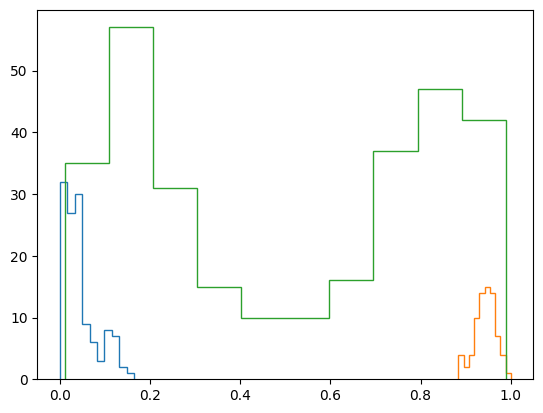

In [84]:
list_ETA = [(0.25, 0.6, 0.15), (0.65, 0.2, 0.15), (0.7, 0.2, 0.1), (0.75, 0.2, 0.05), (0.79, 0.2, 0.01),
            (0.45, 0.4, 0.15), (0.5, 0.4, 0.1), (0.55, 0.4, 0.05), (0.59, 0.4, 0.01),
            (0.3, 0.6, 0.1), (0.35, 0.6, 0.05), (0.39, 0.6, 0.01)]


for ETA in list_ETA:
    
    print(f"ETA: {ETA}")
    
    users_params_prefs = (non_rad_parameter_prefs,
                          rad_users_parameter_prefs, semi_rad_users_parameter_prefs)
    items_params_attrs = (harmful_items_parameter_attrs,
                          neutral_items_parameter_attrs)
    items_slants = (harmful_items_slants, neutral_items_slants)

    #ETA = (0.4, 0.5, 0.1)

    if False: #(ETA[0] + ETA[1] + ETA[2]) != 1.:
        print("ETA does not equal 1")

    else:
        generate_samples(num_users, num_attrs, sim_index,
                         users_params_prefs, items_params_attrs, items_slants, ETA)
    break

In [ ]:
semi_params = np.ones(3)
semi_rad_users_parameter_prefs = rng.dirichlet(
    semi_params, size=10) #* 10
semi_rad_users_parameter_prefs

In [ ]:
semi_rad_users_parameter_prefs_2 = rng.dirichlet(
    semi_rad_users_parameter_prefs[0,:], size=10)
semi_rad_users_parameter_prefs_2